In this notebook we will explore the airbnb seattle data and try to answer the following questions 1-the visitors favourite neighbourhood in Seattle is? 2-what kind of property that visitors mostly look for? But first lets import the libraries we will use and explore our datasets

In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df_cal = pd.read_csv('./calendar.csv')
df_listing = pd.read_csv('./listings.csv')
df_review = pd.read_csv('./reviews.csv')

In [334]:
df_listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [335]:
property_vals = df_listing.property_type.value_counts()
property_vals

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

In [336]:
df_listing.groupby(['neighbourhood_group_cleansed']).count()['number_of_reviews'].sort_values()

neighbourhood_group_cleansed
Interbay                11
Seward Park             44
Magnolia                61
Lake City               67
Delridge                79
Northgate               80
Cascade                 89
Beacon Hill            118
University District    122
Rainier Valley         159
West Seattle           203
Ballard                230
Queen Anne             295
Central Area           369
Downtown               530
Capitol Hill           567
Other neighborhoods    794
Name: number_of_reviews, dtype: int64

In [337]:
df_listing.groupby(['neighbourhood_group_cleansed']).mean()['review_scores_location'].sort_values()

neighbourhood_group_cleansed
Rainier Valley         9.052239
Beacon Hill            9.097087
Interbay               9.111111
Delridge               9.200000
University District    9.252632
Lake City              9.267857
Seward Park            9.282051
Northgate              9.353846
Central Area           9.489028
Cascade                9.569231
Magnolia               9.617021
Other neighborhoods    9.637481
Queen Anne             9.751020
West Seattle           9.765432
Ballard                9.766839
Downtown               9.769737
Capitol Hill           9.823529
Name: review_scores_location, dtype: float64

Here we will start by answering the first question: Visitors favourite neighbourhood is?
I'll just use listings dataset

In [338]:
#Preparing the data

#dropping all the columns I don't need
df= df_listing[['neighbourhood_group_cleansed','number_of_reviews','property_type','price']]
df

,neighbourhood_group_cleansed,number_of_reviews,property_type,price
0,Queen Anne,207,Apartment,$85.00
1,Queen Anne,43,Apartment,$150.00
2,Queen Anne,20,House,$975.00
3,Queen Anne,0,Apartment,$100.00
4,Queen Anne,38,House,$450.00
...,...,...,...,...
3813,Other neighborhoods,1,House,$359.00
3814,Capitol Hill,2,Apartment,$79.00
3815,Rainier Valley,0,House,$93.00
3816,Capitol Hill,0,Condominium,$99.00


In [339]:
#checking if there is no missing values
no_nulls = set(df.columns[df.isnull().mean()==0])
no_nulls # there a column containg missing values(property_type) so will drop them

{'neighbourhood_group_cleansed', 'number_of_reviews', 'price'}

In [340]:
#also the price column datatype needs changing so we can perform calculations
#so a function to change the datatype of a currency from object(as there is a currency symbol therefor considered a string) to float so operations could be done on it
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)


In [341]:
df['price'] = df['price'].apply(clean_currency).astype('float')
df['price'].dtype

<ipython-input-341-ebb15e8be33c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'].apply(clean_currency).astype('float')


dtype('float64')

In [343]:
#dropping rows with missing property type
drop_prop_df = df.dropna(subset=['property_type'], axis=0)

In [345]:
drop_prop_df

,neighbourhood_group_cleansed,number_of_reviews,property_type,price
0,Queen Anne,207,Apartment,85.0
1,Queen Anne,43,Apartment,150.0
2,Queen Anne,20,House,975.0
3,Queen Anne,0,Apartment,100.0
4,Queen Anne,38,House,450.0
...,...,...,...,...
3813,Other neighborhoods,1,House,359.0
3814,Capitol Hill,2,Apartment,79.0
3815,Rainier Valley,0,House,93.0
3816,Capitol Hill,0,Condominium,99.0


In [346]:
#Data Modelling

In [323]:
neighbourhood_reviews = df.groupby(['neighbourhood_group_cleansed']).sum()['number_of_reviews'].sort_values()

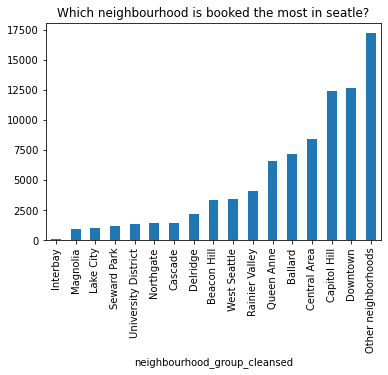

In [328]:
neighbourhood_reviews.plot(kind="bar");
plt.title("Which neighbourhood is booked the most in seatle?");

The above graph answers our first question, showing us that downtown,Capitol Hill, Central area, Ballard and Queen ann areas are the most favourit neighbourhoods to visitors

In [322]:
neighbourhood_price = df.groupby(['neighbourhood_group_cleansed']).mean()['price'].sort_values()

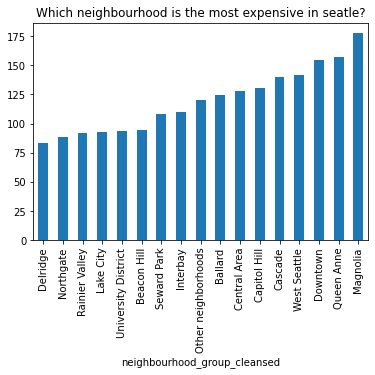

In [329]:
neighbourhood_price.plot(kind="bar");
plt.title("Which neighbourhood is the most expensive in seatle?");


For the second question, we will continue on the same data we prepared for the 1st question. The following will answer which property type is mostly booked by visitors

In [347]:
#since the data is cleaned and ready for use we will jump to modelling right away

#grouping the dataframe by property type and aggregating the sum of the number of reviews which we will consider as a booking made
property_reviews = df.groupby(['property_type']).sum()['number_of_reviews'].sort_values()

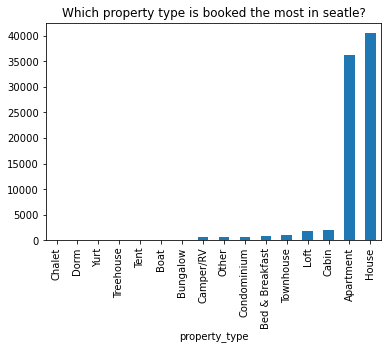

In [327]:
property_reviews.plot(kind="bar");
plt.title("Which property type is booked the most in seatle?");

The graph above answers our second question. Visitors prefare apartments and houses mostly over any other type of property

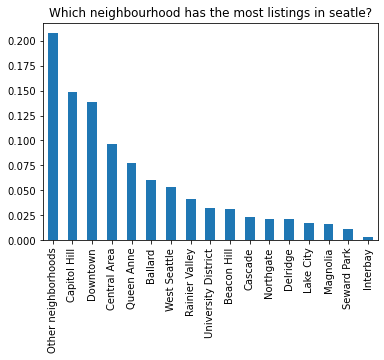

In [325]:
status_vals =df.neighbourhood_group_cleansed.value_counts() 
(status_vals/df.shape[0]).plot(kind="bar");
plt.title("Which neighbourhood has the most listings in seatle?");

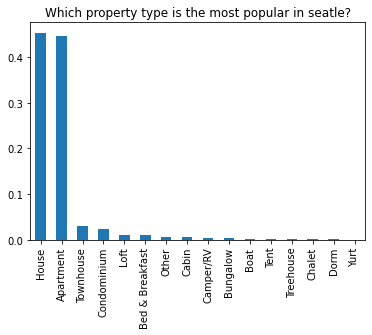

In [326]:
prop_vals =df.property_type.value_counts() 
(prop_vals/df.shape[0]).plot(kind="bar");
plt.title("Which property type is the most popular in seatle?");